## Project: Prediction of skin cancer mortality using machine learning
- **Source**: Stat 462 Applied Regression Analysus, PennState Eberly College of Science, retrieved Oct 2024
- **Date**: 10/02/24
- **Goal**: Create a basic prediction model guide

In [1]:
# Step 0. Import libraries, custom modules and logging
# Basics ---------------------------------------------------------------
import logging
import joblib
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (mean_squared_error, 
                             mean_absolute_error,
                             r2_score)
# Logging initialization -----------------------------------------------
logger = logging.getLogger()
logger.setLevel(logging.INFO)

### 1. Data loading
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [3]:
# Step 1. Load data and get a first view -------------------------------
# 1.1 Read from source and get basic info
df_raw = pd.read_csv('skincancer.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   State   49 non-null     object 
 1   Lat     49 non-null     float64
 2   Mort    49 non-null     int64  
 3   Ocean   49 non-null     int64  
 4   Long    49 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.0+ KB


In [4]:
# 1.2 Get a sample
display(df_raw.sample(5, random_state=2024))

,State,Lat,Mort,Ocean,Long
24,Montana,47.0,109,0,110.5
17,Maine,45.2,117,1,69.0
39,SouthDakota,44.8,86,0,100.0
26,Nevada,39.0,191,0,117.0
12,Indiana,40.2,128,0,86.2


### 2. Data preprocessing
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [8]:
# Step 2. Prepara the dataset for analysis
# 2.1 Make transformations using a pipeline
df_interim = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ','_')
        .str.replace(r'\W','',regex=True)
        .str.lower()
        .str.slice(0,40), axis=1
    )
    .rename(columns={'mort':'target'})
    .astype({'target': np.float16})
    .iloc[:,1:3]
)

In [9]:
# 2.2 Create the final dataset with the target in front, show result
df = (
    df_interim
    .copy()
    .reindex(
        columns=(
            ['target'] + 
            [c for c in df_interim.columns.to_list() if c not in ['target']]
        )
    )
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  49 non-null     float16
 1   lat     49 non-null     float64
dtypes: float16(1), float64(1)
memory usage: 622.0 bytes


### 3. Exploratory Data Analysis
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [59]:
# Step 3. Perform EDA
# 3.1 Split the dataset
df_train, df_test = train_test_split(df, 
                                     random_state=2024, 
                                     test_size=0.2)
df_train = df_train.reset_index(drop=True).sort_values(by='target')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, 28 to 33
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  39 non-null     float16
 1   lat     39 non-null     float64
dtypes: float16(1), float64(1)
memory usage: 702.0 bytes


In [60]:
# 3.2 Get numerical and categorical summaries
display(df_train.describe(include='number').T)

,count,mean,std,min,25%,50%,75%,max
target,39.0,156.625000,32.062500,110.0,133.0,152.0,177.5,229.0
lat,39.0,39.187179,4.629663,28.0,35.5,39.0,43.0,47.5


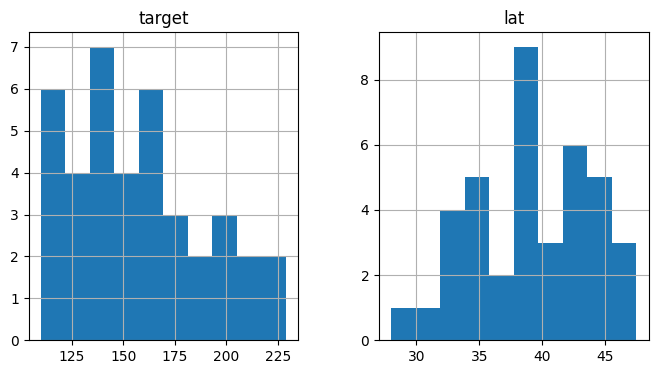

In [61]:
# 3.3 Perform univariate analysis on numerical variables
df_train.hist(figsize=(8,4))
plt.show()

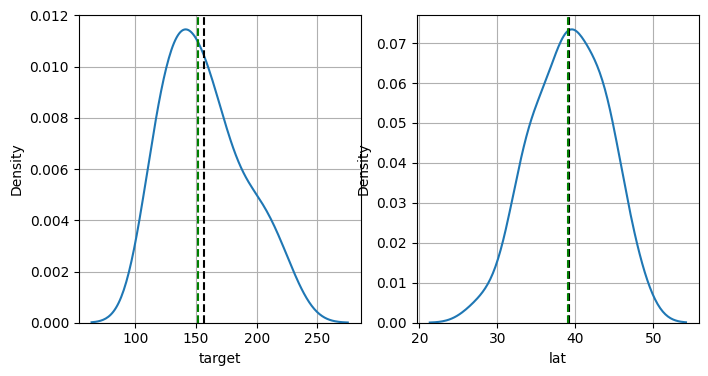

In [62]:
# 3.4 Perform univariate analysis on numerical variables using kde
fig, ax = plt.subplots(1,2, figsize=(8,4))
sns.kdeplot(data=df_train, x='target', ax=ax[0])
ax[0].axvline(x=df_train['target'].mean(), color='k', linestyle='--')
ax[0].axvline(x=df_train['target'].median(), color='g', linestyle='--')
sns.kdeplot(data=df_train, x='lat', ax=ax[1])
ax[1].axvline(x=df_train['lat'].mean(), color='k', linestyle='--')
ax[1].axvline(x=df_train['lat'].median(), color='g', linestyle='--')
ax[0].grid(True)
ax[1].grid(True)
plt.show()

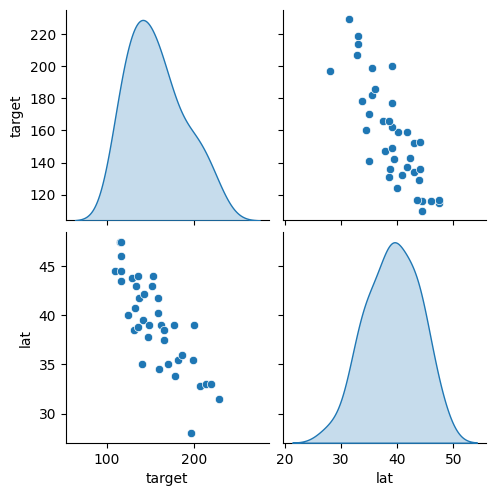

In [63]:
# 3.5 Perform bivariate analysis for numerical values
sns.pairplot(data=df_train, diag_kind='kde')
plt.show()

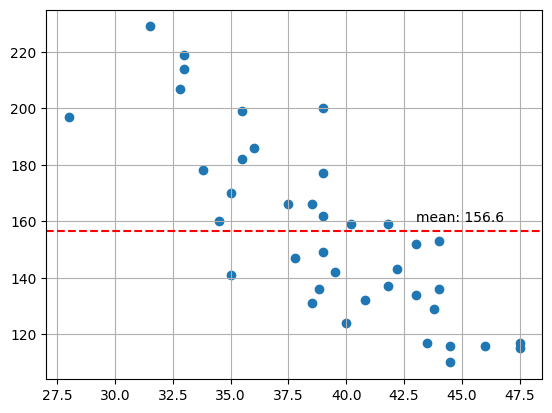

In [64]:
# 3.5 Perform bivariate analysis as a trend
plt.scatter(df_train['lat'],df_train['target'])
plt.axhline(df_train['target'].mean(),linestyle='--', c='r')
plt.annotate(text=f'mean: {df_train['target'].mean():.1f}', xy=(43,160))
plt.grid(True)
plt.show()

### 4. Machine learning
**Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [65]:
# Step 4. Experiment with models
# 4.1 Split features and reponse
X_train = df_train.drop('target', axis=1).reset_index(drop=True)
y_train = df_train['target'].reset_index(drop=True)
X_test = df_test.drop('target', axis=1).reset_index(drop=True)
y_test = df_test['target'].reset_index(drop=True)

In [66]:
# 4.2 Create a naive model, by using the mean, then evaluate
y_mean = np.repeat(df_train['target'].mean(), len(df_test))
print(f'MSE: {mean_squared_error(y_test, y_mean):.2f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_mean)):.2f}')
print(f'MAE: {mean_absolute_error(y_test, y_mean):.2f}')
print(f'R squared: {r2_score(y_test, y_mean):.2f}')

MSE: 1526.00
RMSE: 39.06
MAE: 36.84
R squared: -0.28


In [67]:
# 4.3 Create a linear regression model
# 4.3.1 Train the model and predict
reg_lin = LinearRegression()
reg_lin.fit(X_train, y_train)
y_pred = reg_lin.predict(X_test)

In [68]:
# 4.3.2 Evaluate against test set
print(f'MSE: {mean_squared_error(y_test, y_pred):.2f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred):.2f}')
print(f'R squared: {r2_score(y_test, y_pred):.2f}')

MSE: 455.62
RMSE: 21.35
MAE: 18.43
R squared: 0.62


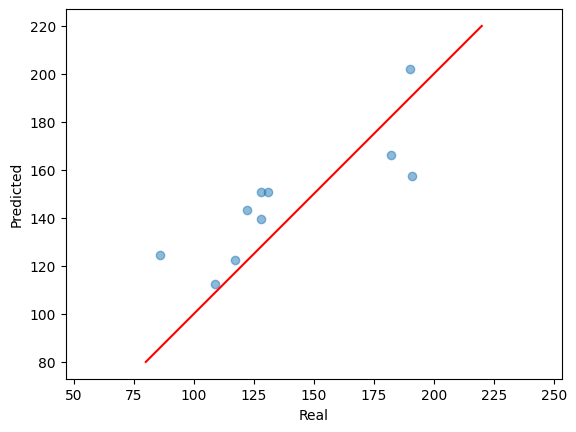

In [78]:
# 4.3.3 Plot the points agaist the prediction
plt.scatter(x=y_test, y=y_pred, alpha=0.5)
plt.plot([80, 220], [80, 220], color='r')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.axis('equal')
plt.show()

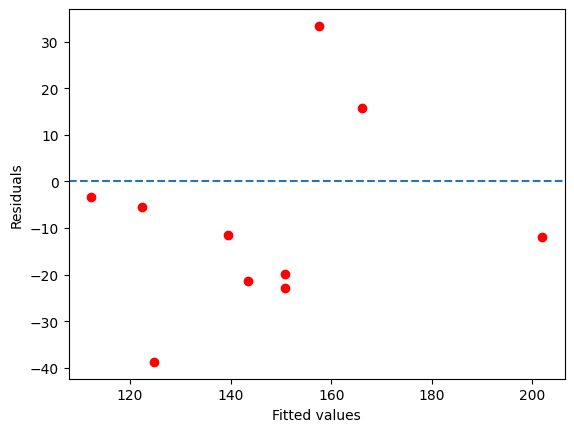

In [95]:
# 4.3.4 Plot the residuals against the fitted values
resid = y_test - y_pred
plt.scatter(x=y_pred, y=resid, c='r')
plt.axhline(0,linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

In [106]:
# 4.3.5 Show the coeficients for the linear equation
print(f'The equation is: {reg_lin.intercept_:.1f} + ({reg_lin.coef_[0]:.1f}*lat)')


The equation is: 378.9 + (-5.7*lat)
